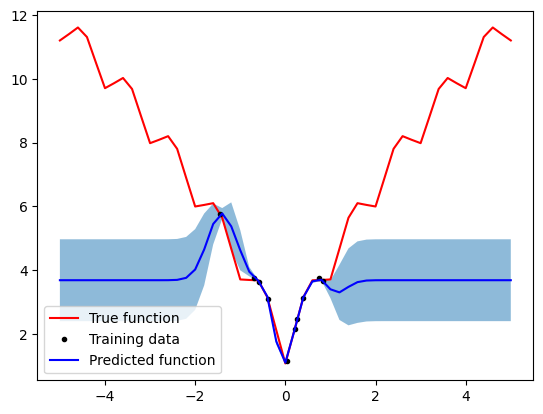

In [7]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

# Define the Ackley function
def ackley(x):
    return -20 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2)) - \
           torch.exp(0.5 * torch.cos(2 * torch.tensor(np.pi) * x)) + 20 + torch.tensor(np.e)

# Generate training data
train_x = torch.randn(10)
train_y = ackley(train_x)

# Define the Gaussian Process model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Evaluate the model on test data
test_x = torch.linspace(-5, 5, 51)
model.eval()
likelihood.eval()
with torch.no_grad():
    observed_pred = likelihood(model(test_x))
    pred_y = observed_pred.mean

# Plot the true function, training data, and predicted function
plt.plot(test_x.numpy(), ackley(test_x).numpy(), 'r', label='True function')
plt.plot(train_x.numpy(), train_y.numpy(), 'k.', label='Training data')
plt.plot(test_x.numpy(), pred_y.numpy(), 'b', label='Predicted function')
plt.fill_between(test_x.numpy(), pred_y.numpy() - observed_pred.stddev.numpy(),
                 pred_y.numpy() + observed_pred.stddev.numpy(), alpha=0.5)
plt.legend()
plt.show()

In [8]:
import numpy as np
import gpytorch

# Load data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * np.pi))

# Standardize target variable
train_y_mean = train_y.mean()
train_y_std = train_y.std()
train_y = (train_y - train_y_mean) / train_y_std

# Define likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Define model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Train model
model = GPRegressionModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
# Make predictions
model.eval()
likelihood.eval()

with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    test_y = torch.sin(test_x * (2 * np.pi))
    test_y_standardized = (test_y - train_y_mean) / train_y_std
    
    observed_pred = likelihood(model(test_x))
    pred_mean = observed_pred.mean * train_y_std + train_y_mean
    lower, upper = observed_pred.confidence_region()
    lower = lower * train_y_std + train_y_mean
    upper = upper * train_y_std + train_y_mean
